## 实验一：图像自动分割算法

In [1]:
# 如果本地没有装 opencv-python 或 matplotlib，可执行:
# !pip install opencv-python matplotlib

import cv2
import numpy as np
import matplotlib.pyplot as plt

# 在 Jupyter Notebook 中内嵌显示图像
%matplotlib inline


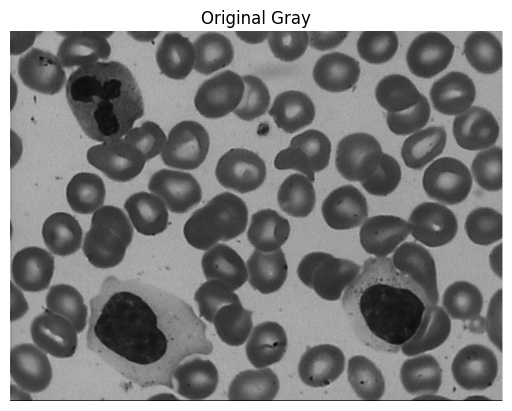

In [2]:
# 读取原始灰度图
gray = cv2.imread('img/gray.bmp', cv2.IMREAD_GRAYSCALE)

if gray is None:
    print("无法读取 gray.bmp，请检查文件是否存在或路径是否正确。")
else:
    # 显示原灰度图
    plt.imshow(gray, cmap='gray')
    plt.title('Original Gray')
    plt.axis('off')
    plt.show()


滤波完成并保存到 gray_smooth.bmp


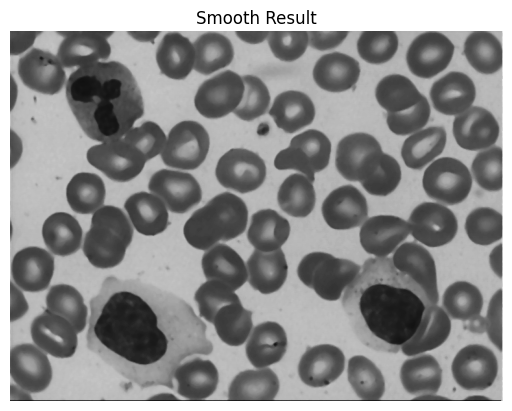

In [3]:
if gray is not None:
    # 中值滤波
    smooth = cv2.medianBlur(gray, 5)

    # 保存并显示
    cv2.imwrite('img/gray_smooth.bmp', smooth)
    print("滤波完成并保存到 gray_smooth.bmp")

    # 显示平滑结果
    plt.imshow(smooth, cmap='gray')
    plt.title('Smooth Result')
    plt.axis('off')
    plt.show()


分割完成并保存到 gray_seg.bmp


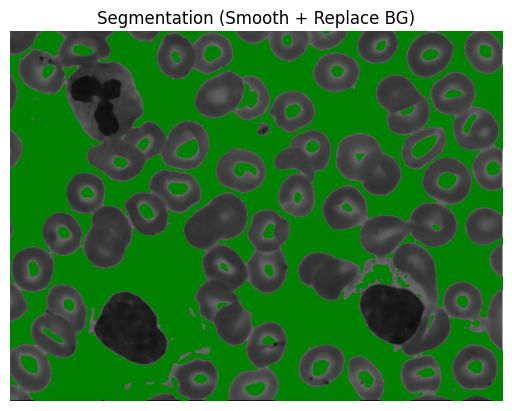

In [4]:
def segment_and_replace_bg(gray_img, kernel_size=3, invert=True):

    # --- 阈值分割 ---
    # 根据 invert 参数决定阈值类型
    thresh_mode = cv2.THRESH_BINARY_INV if invert else cv2.THRESH_BINARY
    # Otsu 自动阈值
    _, mask = cv2.threshold(gray_img, 0, 255, thresh_mode | cv2.THRESH_OTSU)

    # --- 形态学操作 ---
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    # 开运算：去除小的白点
    opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    # 闭运算：填补前景中的小洞
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

    # --- 彩色叠加 ---
    color_seg = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)  # (H,W,3)
    # 背景像素=0 → 替换成绿色
    background_coords = np.where(closed == 0)
    color_seg[background_coords] = (0, 128, 0)  # BGR (0,255,0)

    return color_seg

if gray is not None:
    # 读取我们前面保存的smooth图；也可直接用smooth变量
    smooth_loaded = cv2.imread('img/gray_smooth.bmp', cv2.IMREAD_GRAYSCALE)
    if smooth_loaded is None:
        print("未能读取 gray_smooth.bmp。")
    else:
        seg_result = segment_and_replace_bg(smooth_loaded, kernel_size=3, invert=True)

        # 保存分割结果
        cv2.imwrite('img/gray_seg.bmp', seg_result)
        print("分割完成并保存到 gray_seg.bmp")

        # 显示分割结果
        plt.imshow(cv2.cvtColor(seg_result, cv2.COLOR_BGR2RGB))
        plt.title('Segmentation (Smooth + Replace BG)')
        plt.axis('off')
        plt.show()


与参考分割相比，不一致的像素总数 = 0


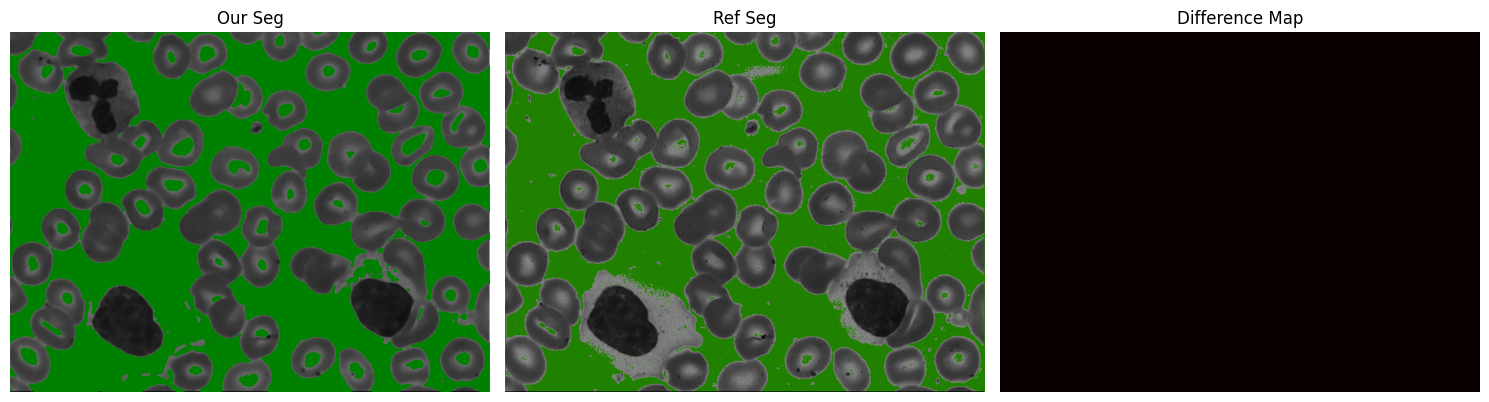

In [5]:
def color_to_mask(color_img, bg_color=(0,255,0)):
    
    # color_img: BGR
    h, w = color_img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    b, g, r = bg_color
    # 找出背景区域
    bg_coords = np.where(
        (color_img[:,:,0] == b) &
        (color_img[:,:,1] == g) &
        (color_img[:,:,2] == r)
    )
    # 其余部分视作前景
    mask[:] = 255
    mask[bg_coords] = 0

    return mask

# 读取我们的分割结果 & 参考结果
our_seg = cv2.imread('img/gray_seg.bmp')     # 我们的分割
ref_seg = cv2.imread('img/gray_ref.bmp')     # 参考分割

if our_seg is None:
    print("无法读取 gray_seg.bmp。")
else:
    if ref_seg is None:
        print("未提供 gray_ref.bmp。")
    else:
        # 生成二值掩膜
        mask_our = color_to_mask(our_seg, (0,255,0))
        mask_ref = color_to_mask(ref_seg, (0,255,0))

        # 计算差异
        diff = cv2.absdiff(mask_our, mask_ref)
        diff_pixels = np.count_nonzero(diff)

        print(f"与参考分割相比，不一致的像素总数 = {diff_pixels}")

        # 可视化
        plt.figure(figsize=(15,5))

        plt.subplot(1,3,1)
        plt.imshow(cv2.cvtColor(our_seg, cv2.COLOR_BGR2RGB))
        plt.title('Our Seg')
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(cv2.cvtColor(ref_seg, cv2.COLOR_BGR2RGB))
        plt.title('Ref Seg')
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(diff, cmap='hot')
        plt.title('Difference Map')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
